In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import regularizers
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pyshark
import os

import nest_asyncio
nest_asyncio.apply()

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')



2024-11-04 10:51:19.169904: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-04 10:51:19.251172: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-04 10:51:19.325377: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730713879.392870   76099 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730713879.413755   76099 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-04 10:51:19.568244: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
# Preprocess log to csv
with open('conn.log.labeled', 'r') as f:
    lines = f.readlines()
    
    with open('conn.log.labeled.csv', 'w') as ff:
        for line in lines[8:-1]:
            line = line.replace('\t', ',').replace('   ', ',')
            ff.write(line)        

In [3]:
# Load training data
#data_train = pd.read_csv('KDDTrain+.txt')

data_train = pd.read_csv('conn.log.labeled.csv')

data_train.head()


,1525879831.015811,CUmrqr4svHuSXJy5z7,192.168.100.103,51524,65.127.233.163,23,tcp,-,2.999051,0,0.1,S0,-.1,-.2,0.2,S,3,180,0.3,0.4,(empty),Malicious,PartOfAHorizontalPortScan
0,1.525880e+09,CH98aB3s1kJeq6SFOc,192.168.100.103,56305,63.150.16.171,23,tcp,-,-,-,-,S0,-,-,0,S,1,60,0,0,(empty),Malicious,PartOfAHorizontalPortScan
1,1.525880e+09,C3GBTkINvXNjVGtN5,192.168.100.103,41101,111.40.23.49,23,tcp,-,-,-,-,S0,-,-,0,S,1,60,0,0,(empty),Malicious,PartOfAHorizontalPortScan
2,1.525880e+09,CDe43c1PtgynajGI6,192.168.100.103,60905,131.174.215.147,23,tcp,-,2.998796,0,0,S0,-,-,0,S,3,180,0,0,(empty),Malicious,PartOfAHorizontalPortScan
3,1.525880e+09,CJaDcG3MZzvf1YVYI4,192.168.100.103,44301,91.42.47.63,23,tcp,-,-,-,-,S0,-,-,0,S,1,60,0,0,(empty),Malicious,PartOfAHorizontalPortScan
4,1.525880e+09,CMBrup3BLXivSp4Avc,192.168.100.103,50244,120.210.108.200,23,tcp,-,-,-,-,S0,-,-,0,S,1,60,0,0,(empty),Malicious,PartOfAHorizontalPortScan


In [4]:
columns = (["ts", "uid", "id.orig_h", "id.orig_p", "id.resp_h", "id.resp_p", "proto", "service", "duration", "orig_bytes", "resp_bytes", "conn_state", "local_orig", "local_resp", "missed_bytes", "history", "orig_pkts", "orig_ip_bytes", "resp_pkts", "resp_ip_bytes", "tunnel_parents", "label", "detailed-label"])

data_train.columns = columns


data_train.head()


,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,label,detailed-label
0,1.525880e+09,CH98aB3s1kJeq6SFOc,192.168.100.103,56305,63.150.16.171,23,tcp,-,-,-,-,S0,-,-,0,S,1,60,0,0,(empty),Malicious,PartOfAHorizontalPortScan
1,1.525880e+09,C3GBTkINvXNjVGtN5,192.168.100.103,41101,111.40.23.49,23,tcp,-,-,-,-,S0,-,-,0,S,1,60,0,0,(empty),Malicious,PartOfAHorizontalPortScan
2,1.525880e+09,CDe43c1PtgynajGI6,192.168.100.103,60905,131.174.215.147,23,tcp,-,2.998796,0,0,S0,-,-,0,S,3,180,0,0,(empty),Malicious,PartOfAHorizontalPortScan
3,1.525880e+09,CJaDcG3MZzvf1YVYI4,192.168.100.103,44301,91.42.47.63,23,tcp,-,-,-,-,S0,-,-,0,S,1,60,0,0,(empty),Malicious,PartOfAHorizontalPortScan
4,1.525880e+09,CMBrup3BLXivSp4Avc,192.168.100.103,50244,120.210.108.200,23,tcp,-,-,-,-,S0,-,-,0,S,1,60,0,0,(empty),Malicious,PartOfAHorizontalPortScan


In [5]:
data_train.describe().style.background_gradient(cmap='Blues').set_properties(**{'font-family':'Segoe UI'})

,ts,id.orig_p,id.resp_p,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
count,1008747.000000,1008747.000000,1008747.000000,1008747.000000,1008747.000000,1008747.000000,1008747.000000,1008747.000000
mean,1526075007.413106,44436.835802,16097.724068,0.000000,1.496240,81.145521,0.142465,9.049193
std,115743.041224,9660.594080,19562.798396,0.000000,1.741176,94.730897,1.850415,119.677623
min,1525879831.015073,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1525975061.018526,43730.000000,23.000000,0.000000,1.000000,40.000000,0.000000,0.000000
50%,1526071200.014103,43763.000000,8080.000000,0.000000,1.000000,60.000000,0.000000,0.000000
75%,1526174020.006510,48814.000000,28180.500000,0.000000,1.000000,60.000000,0.000000,0.000000
max,1526282683.030512,65394.000000,65535.000000,0.000000,60.000000,2990.000000,75.000000,9415.000000


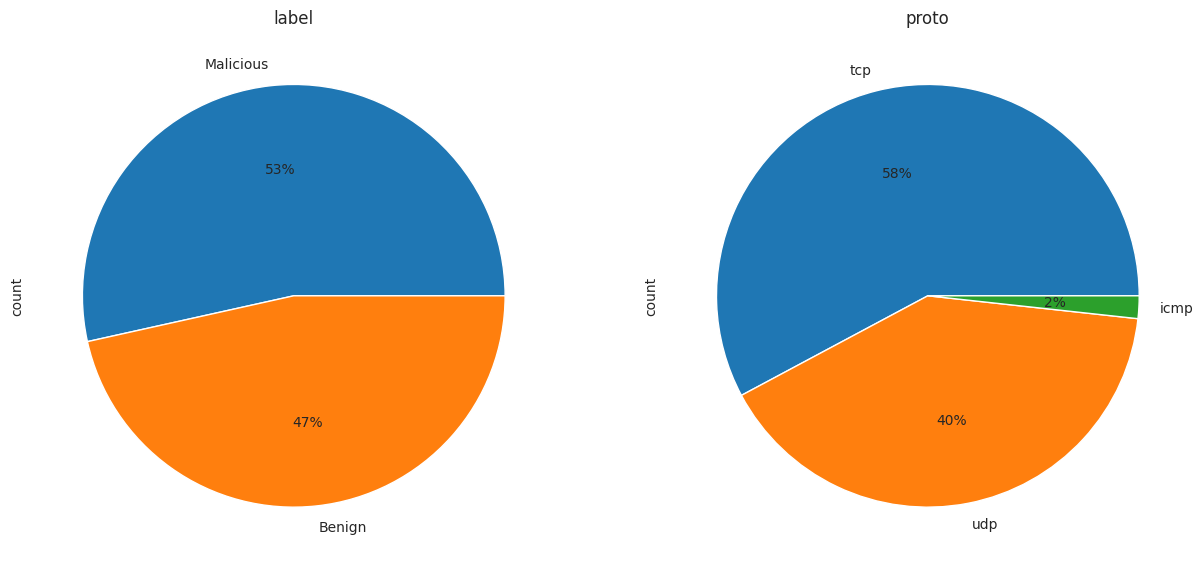

In [6]:
def pie_plot(df, cols_list, rows, cols):
    fig, axes = plt.subplots(rows, cols)
    for ax, col in zip(axes.ravel(), cols_list):
        df[col].value_counts().plot(ax=ax, kind='pie', figsize=(15, 15), fontsize=10, autopct='%1.0f%%')
        ax.set_title(str(col), fontsize = 12)
    plt.show()
    

pie_plot(data_train, ["label", "proto"], 1, 2)



In [7]:
def Scaling(df_num, cols):
    std_scaler = RobustScaler()
    std_scaler_temp = std_scaler.fit_transform(df_num)
    std_df = pd.DataFrame(std_scaler_temp, columns=cols)
    return std_df


def preprocess(dataframe):
    # Define categorical columns for one-hot encoding
    cat_cols = ["proto", "service", "conn_state", "history"]
    
    # Drop unnecessary columns
    dataframe = dataframe.drop(columns=["ts", "uid", "id.orig_h", "id.resp_h", "id.orig_p", "id.resp_p", "tunnel_parents", "detailed-label"], errors='ignore')
    
    # Replace '-' with NaN for handling as missing values
    dataframe.replace('-', np.nan, inplace=True)
    
    # Identify numeric columns, converting all possible columns to numeric first
    numeric_cols = dataframe.columns.difference(cat_cols + ["label"])
    for col in numeric_cols:
        dataframe[col] = pd.to_numeric(dataframe[col], errors='coerce')
    
    # Create a subset of the dataframe with numeric columns
    df_num = dataframe[numeric_cols]
    
    # Identify columns that are fully NaN
    all_nan_cols = df_num.columns[df_num.isna().all()]
    if len(all_nan_cols) > 0:
        print(f"Columns with all NaN values: {all_nan_cols}")
        # Uncomment the line that you want to use for handling all-NaN columns
        # df_num.drop(columns=all_nan_cols, inplace=True)  # Option 1: Drop columns with all NaNs
        df_num[all_nan_cols] = 0  # Option 2: Fill NaNs with 0

    # Perform imputation on numeric columns
    imputer = SimpleImputer(strategy='mean')
    imputed_values = imputer.fit_transform(df_num)
    
    # Recreate DataFrame with imputed values, checking alignment
    df_num = pd.DataFrame(imputed_values, columns=numeric_cols, index=dataframe.index)
    
    # Scale numeric columns
    scaled_df = Scaling(df_num, df_num.columns)
    
    # Update the original DataFrame with scaled values
    dataframe[df_num.columns] = scaled_df.values
    
    # Convert 'label' to binary: "Malicious" = 1, "normal" = 0
    dataframe["label"] = dataframe["label"].apply(lambda x: 0 if x == "Benign" else 1)
    
    # Make sure the dataset contains both Malicious and Benign samples
    #if dataframe["label"].nunique() < 2:
     #   raise ValueError("Dataset must contain both Malicious and Benign samples.")
    
    # One-hot encode the categorical columns
    dataframe = pd.get_dummies(dataframe, columns=cat_cols, drop_first=True)
    
    return dataframe



In [8]:
# Apply preprocessing
scaled_train = preprocess(data_train)

# Print a sample of both malicious and normal data
malicious_sample = scaled_train[scaled_train['label'] == 1].sample(5, random_state=42)
normal_sample = scaled_train[scaled_train['label'] == 0].sample(5, random_state=42)

print("Malicious Sample:")
print(malicious_sample)
print("\nNormal Sample:")
print(normal_sample)


# Separate features and targets
x = scaled_train.drop(['label'], axis=1, errors='ignore').values.astype('float32')
y = scaled_train['label'].values.astype('int')

# Perform PCA on features after handling NaNs
pca = PCA(n_components=20)
x_reduced = pca.fit_transform(x)

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_reduced, y, test_size=0.2, random_state=42)


Columns with all NaN values: Index(['local_orig', 'local_resp'], dtype='object')
Malicious Sample:
        duration  orig_bytes  resp_bytes  local_orig  local_resp  \
391309       0.0         0.0         0.0         0.0         0.0   
166433       0.0         0.0         0.0         0.0         0.0   
830187       0.0         0.0         0.0         0.0         0.0   
601910       0.0         0.0         0.0         0.0         0.0   
903077       0.0         0.0         0.0         0.0         0.0   

        missed_bytes  orig_pkts  orig_ip_bytes  resp_pkts  resp_ip_bytes  \
391309           0.0        0.0            0.0        0.0            0.0   
166433           0.0        0.0            0.0        0.0            0.0   
830187           0.0        0.0            0.0        0.0            0.0   
601910           0.0        0.0            0.0        0.0            0.0   
903077           0.0        0.0            0.0        0.0            0.0   

        label  proto_tcp  proto_udp

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', input_shape=(x_train.shape[1:]),
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu',
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=512, activation='relu',
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu',
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])

model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=2, verbose=1)

Epoch 1/2
25219/25219 ━━━━━━━━━━━━━━━━━━━━ 95s 4ms/step - accuracy: 0.9494 - loss: 0.8273 - val_accuracy: 0.9568 - val_loss: 0.1631
Epoch 2/2
25219/25219 ━━━━━━━━━━━━━━━━━━━━ 74s 3ms/step - accuracy: 0.9571 - loss: 0.1639 - val_accuracy: 0.9569 - val_loss: 0.1619


In [11]:
# Load the pcap file
capture = pyshark.FileCapture('2018-07-25-10-53-16-192.168.100.111.pcap')

In [12]:
# Process packets
packet_data = []
for i, packet in enumerate(capture):
    if i > 10000:
        break

    if i % 1000 == 0:
        print("Reached", i)
    
    try:
        packet_info = {
            'duration': float(packet.sniff_time.timestamp()),  # Duration based on capture time
            'protocol_type': packet.highest_layer,             # Protocol type (e.g., TCP, UDP)
            'service': packet.transport_layer if hasattr(packet, 'transport_layer') else 'unknown',  # Transport layer protocol
            'flag': int(packet.tcp.flags, 16) if hasattr(packet, 'tcp') else 0,  # TCP flags in decimal format
            'src_bytes': int(packet.length),                   # Source bytes (packet length)
            'dst_bytes': int(packet.ip.len) - int(packet.length) if hasattr(packet, 'ip') else 0,  # Destination bytes if IP length is available
            'land': 1 if hasattr(packet, 'ip') and packet.ip.src == packet.ip.dst else 0,  # Check if src equals dst
            'orig_pkts': 1,                                    # Packet count, initialized to 1 for each packet
            'missed_bytes': 0                                  # Placeholder for missed bytes, set to 0
        }
        packet_data.append(packet_info)
    except AttributeError:
        continue

Reached 0
Reached 1000
Reached 2000
Reached 3000
Reached 4000
Reached 5000
Reached 6000
Reached 7000
Reached 8000
Reached 9000
Reached 10000


In [11]:
# Preprocess test data log
with open('test.log.labeled', 'r') as f:
    lines = f.readlines()
    
    with open('test.log.labeled.csv', 'w') as ff:
        for line in lines[8:-1]:
            line = line.replace('\t', ',').replace('   ', ',')
            ff.write(line)        

In [ ]:
# Convert to DataFrame and preprocess
df = pd.read_csv('test.log.labeled.csv')

columns = (["ts", "uid", "id.orig_h", "id.orig_p", "id.resp_h", "id.resp_p", "proto", "service", "duration", "orig_bytes", "resp_bytes", "conn_state", "local_orig", "local_resp", "missed_bytes", "history", "orig_pkts", "orig_ip_bytes", "resp_pkts", "resp_ip_bytes", "tunnel_parents", "label", "detailed-label"])

df.columns = columns


df.head()


# Add missing columns that were in the training data but might not be in new data
required_columns = ["proto", "service", "conn_state", "history", "local_orig", 
                   "local_resp", "orig_bytes", "resp_bytes", "orig_ip_bytes", 
                   "resp_ip_bytes", "resp_pkts"]

# Add missing columns with default values
for col in required_columns:
    if col not in df.columns:
        df[col] = np.nan

# Add history column with a default value
if 'history' not in df.columns:
    df['history'] = 'S'  # Simple default value for history

# Add label column (will be dropped during preprocessing)
df['label'] = 'unknown'

# Preprocess the new data using the same function as training data
preprocessed_new_data = preprocess(df)

# Ensure columns match training data
train_columns = scaled_train.drop('label', axis=1).columns
missing_cols = set(train_columns) - set(preprocessed_new_data.columns)
for col in missing_cols:
    preprocessed_new_data[col] = 0  # Add missing columns with default values

# Reorder columns to match training data
preprocessed_new_data = preprocessed_new_data[train_columns]

# Convert to numpy array for prediction
x_new = preprocessed_new_data.values.astype('float32')

# Transform with PCA using the fitted PCA object
x_new_reduced = pca.transform(x_new)

# Make predictions
predictions = model.predict(x_new_reduced)
predicted_outcomes = (predictions > 0.5).astype('int')

# Add predictions to original DataFrame
df['predicted_outcome'] = predicted_outcomes

# Save predictions
os.makedirs('data', exist_ok=True)  # Create data directory if it doesn't exist
df.to_csv('data/predicted_new_data.csv', index=False)
print("Predictions saved to 'data/predicted_new_data.csv'")

Prediction Summary:
Total packets analyzed: 10001
Normal packets detected: 9982 (99.81%)
Malicious packets detected: 19 (0.19%)




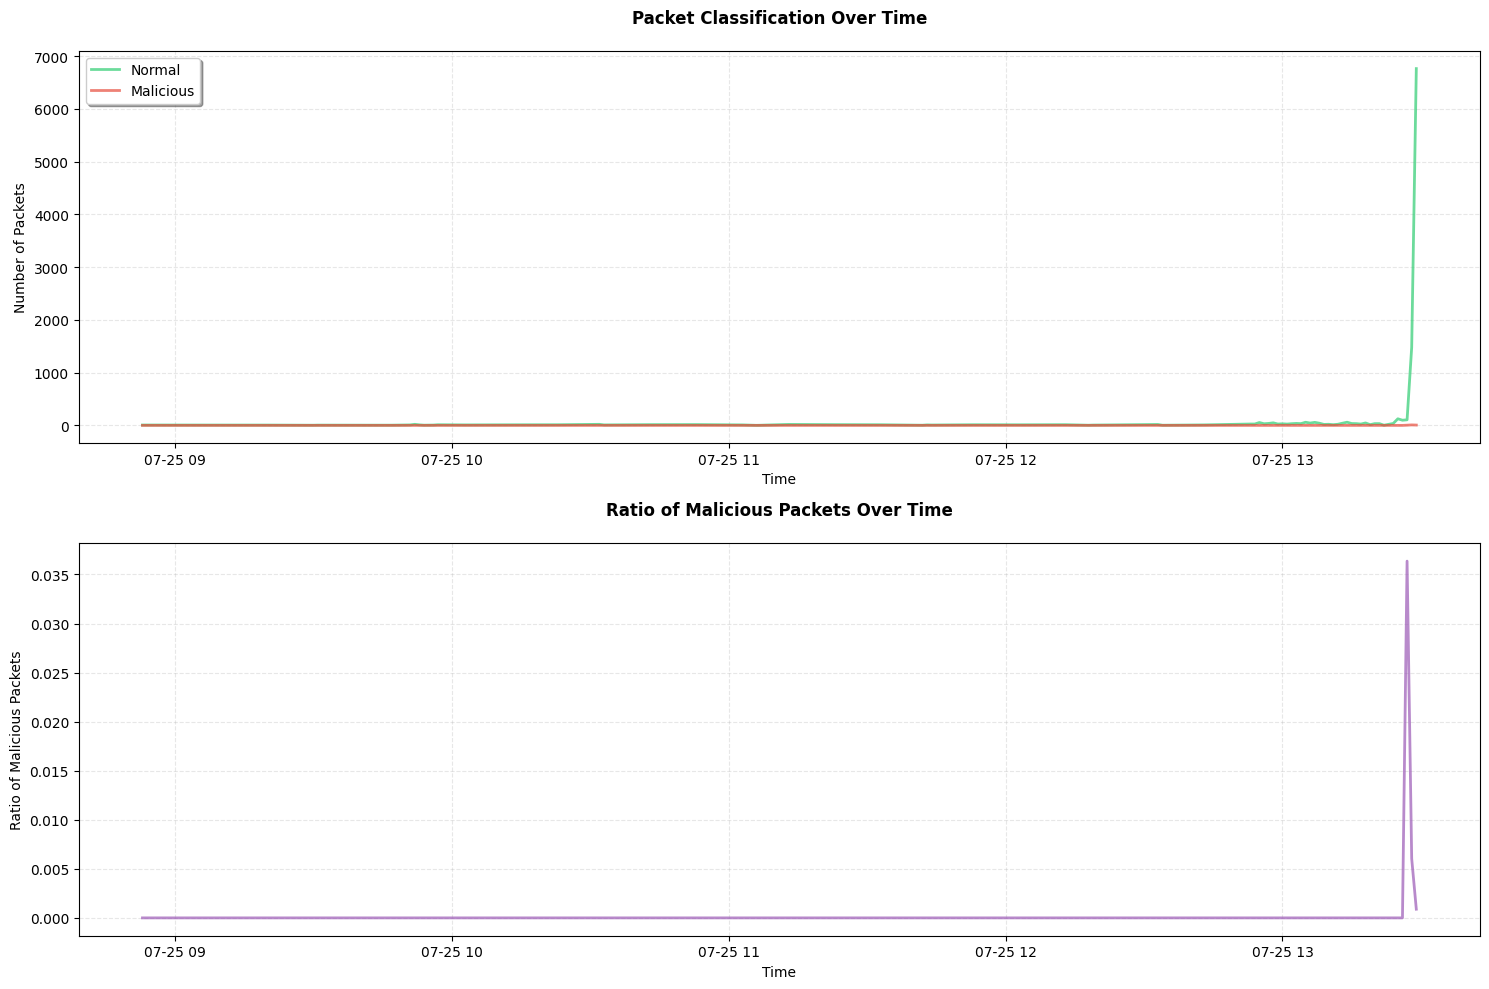


Protocol-based Analysis:
               total_packets  malicious_packets  malicious_ratio  \
protocol_type                                                      
ARP                      344                 19           0.0552   
BT-DHT                  1050                  0           0.0000   
DATA                     343                  0           0.0000   
DNS                      179                  0           0.0000   
ICMP                       3                  0           0.0000   
NTP                       39                  0           0.0000   
SSDP                       4                  0           0.0000   
SSH                       13                  0           0.0000   
TCP                     8015                  0           0.0000   
UAUDP                     11                  0           0.0000   

               normal_packets  
protocol_type                  
ARP                       325  
BT-DHT                   1050  
DATA                      343

<Figure size 1200x600 with 0 Axes>

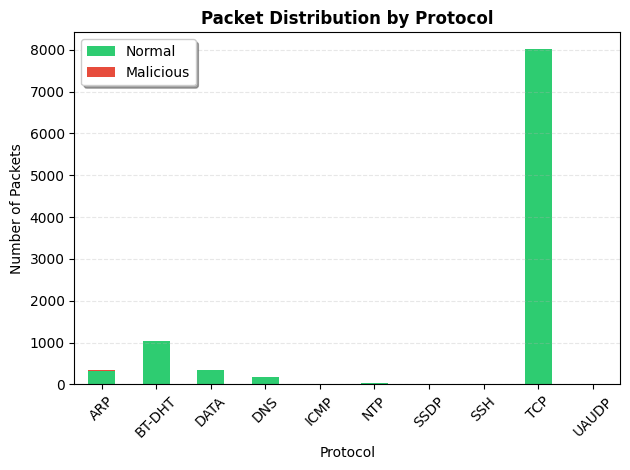


Src Bytes Analysis:
Average size of normal packets: 77.66
Average size of malicious packets: 60.00

Dst Bytes Analysis:
Average size of normal packets: -18.35
Average size of malicious packets: 0.00

Potential Anomalies:
Found 1 time periods with unusual spikes in malicious traffic:
Time: 2018-07-25 13:27:00, Malicious ratio: 3.64%
Error saving results: name 'json' is not defined

Available columns in the DataFrame:
['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'orig_pkts', 'missed_bytes', 'predicted_outcome', 'timestamp', 'minute']


In [32]:
# Calculate basic statistics about predictions
total_packets = len(predicted_outcomes)
malicious_packets = np.sum(predicted_outcomes)
normal_packets = total_packets - malicious_packets
malicious_percentage = (malicious_packets / total_packets) * 100

print("Prediction Summary:")
print(f"Total packets analyzed: {total_packets}")
print(f"Normal packets detected: {normal_packets} ({100-malicious_percentage:.2f}%)")
print(f"Malicious packets detected: {malicious_packets} ({malicious_percentage:.2f}%)")
print("\n")

# Create time-based analysis
df['timestamp'] = pd.to_datetime(df['duration'], unit='s')
df['minute'] = df['timestamp'].dt.floor('T')

# Analyze predictions over time
temporal_analysis = df.groupby('minute').agg({
    'predicted_outcome': ['count', 'sum']
}).reset_index()
temporal_analysis.columns = ['minute', 'total_packets', 'malicious_packets']
temporal_analysis['normal_packets'] = temporal_analysis['total_packets'] - temporal_analysis['malicious_packets']
temporal_analysis['malicious_ratio'] = temporal_analysis['malicious_packets'] / temporal_analysis['total_packets']

# Set up the visualization
plt.style.use('default')  # Use default style instead of seaborn
fig = plt.figure(figsize=(15, 10))

# Plot 1: Timeline of predictions
plt.subplot(2, 1, 1)
plt.plot(temporal_analysis['minute'], temporal_analysis['normal_packets'], 
         label='Normal', color='#2ecc71', alpha=0.7, linewidth=2)  # Use hex color codes
plt.plot(temporal_analysis['minute'], temporal_analysis['malicious_packets'], 
         label='Malicious', color='#e74c3c', alpha=0.7, linewidth=2)
plt.title('Packet Classification Over Time', pad=20, fontsize=12, fontweight='bold')
plt.xlabel('Time', fontsize=10)
plt.ylabel('Number of Packets', fontsize=10)
plt.legend(frameon=True, fancybox=True, shadow=True)
plt.grid(True, alpha=0.3, linestyle='--')

# Plot 2: Malicious ratio over time
plt.subplot(2, 1, 2)
plt.plot(temporal_analysis['minute'], temporal_analysis['malicious_ratio'], 
         color='#9b59b6', alpha=0.7, linewidth=2)
plt.title('Ratio of Malicious Packets Over Time', pad=20, fontsize=12, fontweight='bold')
plt.xlabel('Time', fontsize=10)
plt.ylabel('Ratio of Malicious Packets', fontsize=10)
plt.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Protocol-based analysis using protocol_type
if 'protocol_type' in df.columns:
    try:
        protocol_analysis = df.groupby('protocol_type').agg({
            'predicted_outcome': ['count', 'sum', 'mean']
        })
        protocol_analysis.columns = ['total_packets', 'malicious_packets', 'malicious_ratio']
        protocol_analysis['normal_packets'] = protocol_analysis['total_packets'] - protocol_analysis['malicious_packets']
        
        print("\nProtocol-based Analysis:")
        print(protocol_analysis.round(4))
        
        # Visualize protocol distribution
        plt.figure(figsize=(12, 6))
        ax = protocol_analysis[['normal_packets', 'malicious_packets']].plot(
            kind='bar', 
            stacked=True,
            color=['#2ecc71', '#e74c3c']
        )
        plt.title('Packet Distribution by Protocol', fontsize=12, fontweight='bold')
        plt.xlabel('Protocol', fontsize=10)
        plt.ylabel('Number of Packets', fontsize=10)
        plt.legend(['Normal', 'Malicious'], frameon=True, fancybox=True, shadow=True)
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3, linestyle='--', axis='y')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not complete protocol analysis: {str(e)}")

# Packet size analysis using available byte information
for size_col in ['src_bytes', 'dst_bytes']:
    if size_col in df.columns:
        try:
            normal_mean = np.mean(df[df['predicted_outcome'] == 0][size_col].values)
            malicious_mean = np.mean(df[df['predicted_outcome'] == 1][size_col].values)
            
            print(f"\n{size_col.replace('_', ' ').title()} Analysis:")
            print(f"Average size of normal packets: {normal_mean:.2f}")
            print(f"Average size of malicious packets: {malicious_mean:.2f}")
        except Exception as e:
            print(f"Could not analyze {size_col}: {str(e)}")

# Check for potential anomalies
print("\nPotential Anomalies:")

try:
    # Sudden spikes in malicious traffic
    spike_threshold = temporal_analysis['malicious_ratio'].mean() + 2 * temporal_analysis['malicious_ratio'].std()
    spikes = temporal_analysis[temporal_analysis['malicious_ratio'] > spike_threshold]
    if not spikes.empty:
        print(f"Found {len(spikes)} time periods with unusual spikes in malicious traffic:")
        for _, spike in spikes.iterrows():
            print(f"Time: {spike['minute']}, Malicious ratio: {spike['malicious_ratio']:.2%}")
    else:
        print("No significant spikes in malicious traffic detected.")
except Exception as e:
    print(f"Could not complete anomaly detection: {str(e)}")

# Generate summary statistics
summary_stats = {
    'total_packets': total_packets,
    'malicious_packets': int(malicious_packets),
    'normal_packets': int(normal_packets),
    'malicious_percentage': float(malicious_percentage),
    'analysis_timestamp': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'available_features': df.columns.tolist()
}

# Add additional statistics if available
if 'duration' in df.columns:
    summary_stats['total_duration_seconds'] = float(df['duration'].max() - df['duration'].min())

# Save results
try:
    os.makedirs('data', exist_ok=True)
    
    # Save summary statistics
    with open('data/verification_results.json', 'w') as f:
        json.dump(summary_stats, f, indent=4)
    print("\nVerification results saved to 'data/verification_results.json'")
    
    # Save temporal analysis
    temporal_analysis.to_csv('data/temporal_analysis.csv', index=False)
    print("Temporal analysis saved to 'data/temporal_analysis.csv'")
    
except Exception as e:
    print(f"Error saving results: {str(e)}")

# Print available columns for debugging
print("\nAvailable columns in the DataFrame:")
print(df.columns.tolist())